In [1]:
import numpy as np, xarray as xr
import matplotlib, matplotlib.pyplot as plt

import utilities, visualization

In [2]:
def meridional(v):
    # Gravitational constant [m s^{-2}]
    g = 9.81
    # Earth radius, approximate [m]
    a = 6.371e6
    # Streamfunction container array
    psi = np.full(shape=(len(v.pfull), len(v.grid_yt)), fill_value=0, dtype=float)
    # Get pressure differentials (dp, Pa)
    dp = v['pfull'].diff('pfull').values * 100
    # Iterate over pressure
    # Use meridional streamfunction provided in Peixoto and Oort (1992), Section 14.5.5
    for i, p in enumerate(v.pfull.values[:-1]):
        # print('Index: {0}; pressure level: {1:.2f} hPa'.format(i, p))
        # Sub-iterate over every pressure level through the given one
        for j in range(0, i):
            sp = v.isel(pfull=j).pfull
            # print('Subindex: {0}; subpressure level: {1:.2f} hPa'.format(j, sp))
            # Add the subiterand velocity-pressure differential product to the iterand circulation entry
            psi[i, :] += v.isel(pfull=j)*dp[j]
    # Factor to normalize streamfunction values
    factor = 2*np.pi*a*np.cos(v.grid_yt.values*np.pi/180)/g
    # Multiply the factor by psi
    psi = psi * factor[:, np.newaxis].T
    # Recast as a DataArray
    psi = xr.DataArray(data=psi,
                       dims=['pfull', 'grid_yt'],
                       coords={'pfull': (['pfull'], v.pfull.values),
                               'grid_yt': (['grid_yt'], v.grid_yt.values)})

    return psi

In [3]:
model = 'FLOR'
years = [2001, 2100]
data = {'control': {'vcomp': {'path': '/projects/GEOCLIM/gr7610/analysis/model_out/model_{0}-exp_CTL1990s-type_atmos-var_vcomp-mean_month-resample-full-{1}_{2}.nc'.format(model, min(years), max(years)),
                              'data': None}},
        'swishe': {'vcomp': {'path': '/projects/GEOCLIM/gr7610/analysis/model_out/model_{0}-exp_CTL1990s_swishe-type_atmos-var_vcomp-mean_month-resample-full-{1}_{2}.nc'.format(model, min(years), max(years)),
                              'data': None}}}
years = 25
months = (1, 12)
for experiment in data.keys():
    for field in data[experiment].keys():
        field = 'vcomp'
        # Extract data over the year range specified
        temp = xr.open_dataset(data[experiment][field]['path'])[field].isel(time=slice(-12*years, -1))
        min_year, max_year = temp.time.dt.year.min().item(), temp.time.dt.year.max().item()
        # Get the zonal and time means
        data[experiment][field]['data'] = temp.sel(time=utilities.month_selector(temp.time.dt.month, min(months), max(months))).mean(dim='grid_xt').mean(dim='time')

In [4]:
for experiment in data.keys():
    u, v = data[experiment]['vcomp']['data'], data[experiment]['vcomp']['data']
    data[experiment]['psi'] = {'data': meridional(v)}

#### Comparison approach 1: comparative looks, side-by-side

Text(0.125, 1.05, 'FLOR, 2076 to 2100; annually-averaged')

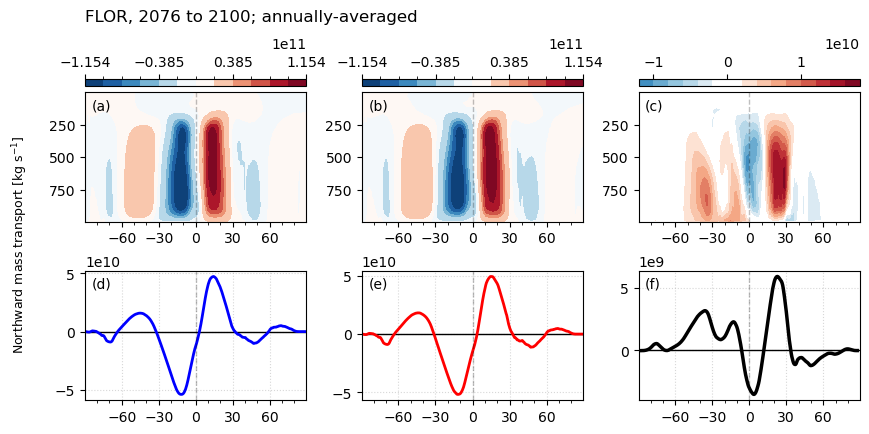

In [5]:
fig = plt.figure(figsize=(10, 4), constrained_layout=True)
gs = matplotlib.gridspec.GridSpec(nrows=2, ncols=3, wspace=0.25, hspace=0.375)
levels = 14
norm, cmap = visualization.norm_cmap([data['control']['psi']['data'], data['swishe']['psi']['data']], 'psi', 
                                     num_bounds=levels, white_adjust=True)

axes = {}
subplot_counter = 0
letters = 'abcdefghijklmnopqstuvwxyz'
fig.supylabel('Northward mass transport [kg s$^{-1}$]', fontsize=9, x=0.05)

''' Zonal mean contours. '''
row_num = 0
for i, experiment in enumerate(data.keys()):
    ax = fig.add_subplot(gs[row_num, i])
    im = ax.contourf(data[experiment]['vcomp']['data'].grid_yt, data[experiment]['vcomp']['data'].pfull, 
                          data[experiment]['psi']['data'], 
                          levels=levels, norm=norm, cmap=cmap)
    axes['({0}, {1})'.format(row_num, i)] = ax
    
for ax in fig.axes:
    ax.set_ylim(ax.get_ylim()[::-1])
    cax = ax.inset_axes([0, 1.05, 1, 0.05])
    colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, cmap), cax=cax, orientation='horizontal')
    cax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(norm.boundaries[::4]))
    cax.xaxis.tick_top()
    
ax = fig.add_subplot(gs[row_num, -1])
im = ax.contourf(data[experiment]['vcomp']['data'].grid_yt, data[experiment]['vcomp']['data'].pfull, 
                 data['swishe']['psi']['data'] - data['control']['psi']['data'], 
                 levels=levels, norm=matplotlib.colors.CenteredNorm(), cmap=cmap)
cax = ax.inset_axes([0, 1.05, 1, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')
cax.xaxis.tick_top()
cax.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())
cax.xaxis.tick_top()
ax.set_ylim(ax.get_ylim()[::-1])
axes['({0}, {1})'.format(row_num, -1)] = ax

''' Pressure means. '''

colors = ['b', 'r']
row_num = 1

for i, experiment in enumerate(data.keys()):
    ax = fig.add_subplot(gs[row_num, i], sharex=axes['({0}, {1})'.format(row_num-1, i)])
    ax.axhline(0, c='k', lw=1)
    im = ax.plot(data[experiment]['vcomp']['data'].grid_yt, data[experiment]['psi']['data'].mean(dim='pfull'), 
                 c=colors[i], label=experiment, lw=2)
    axes['({0}, {1})'.format(row_num, i)] = ax
    ax.grid(alpha=0.5, ls=':')

ax = fig.add_subplot(gs[row_num, -1], sharex=axes['({0}, {1})'.format(row_num-1, i)])
rolling_degree = 5
x, p = [data[experiment]['vcomp']['data'].grid_yt.rolling(grid_yt=int(rolling_degree/0.5)).mean(),
        (data['swishe']['psi']['data'] - data['control']['psi']['data']).mean(dim='pfull').rolling(grid_yt=int(rolling_degree/0.5)).mean()]
ax.axhline(0, c='k', lw=1)
ax.plot(x, p, c='k', lw=2.5)
axes['({0}, {1})'.format(row_num, -1)] = ax
ax.grid(alpha=0.5, ls=':')

for i, ax in enumerate(fig.axes):
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(30))
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(10))
    ax.axvline(0, c='k', lw=1, ls='--', alpha=0.25)
    ax.annotate('({0})'.format(letters[i]), xy=(0.03, 0.95), xycoords='axes fraction', ha='left', va='top')

month_str = [utilities.month_letter(m) for m in range(min(months), max(months)+1)]
month_str = ''.join(month_str) if len(month_str) < 12 else 'annually-averaged'
title_xpos = axes['(0, 0)'].get_position().get_points()[0, 0]
title_str = '{0}, {1} to {2}; {3}'.format(model, min_year, max_year, month_str)
fig.suptitle(title_str, x=title_xpos, y=1.05, ha='left', va='bottom')